# chap7. 시계열 데이터를 다뤄보자

- 웹 트래픽이나 주식 같이 시간의 흐름에 따라 변화하는 데이터를 예측해야 할 상황이 있음.  
- **시계열(time series)** 분석은 통계적으로 어렵고 복잡한 작업.
- 원 데이터의 안정성(stationary)을 판정하고, 안정한 형태로 변환하고, 예측 모델을 선정하고 검증하는 과정이 통계학의 깊은 지식을 요구
- 전문가에게 맡기기 전 간단히 데이터를 예측하는 가벼운 도구 : 페이스북에서 만든 **fbprophet** 모듈
- pip으로 설치 필요 : `pystan`, `prophet`

## 7-1. Numpy의 polyfit으로 회귀(regression) 분석하기

- `pip install pandas_datareader`
- `pip install fbprophet`

- `cannot import name 'is_list_like'` 오류는 버전에 따른 오류
- [stack overflow의 답변](https://stackoverflow.com/questions/50394873/import-pandas-datareader-gives-importerror-cannot-import-name-is-list-like?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa)대로 해결하면 됨

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt

from fbprophet import Prophet
from datetime import datetime

In [2]:
import platform
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    print('Unknown system.')
    
plt.rcParams['axes.unicode_minus'] = False

In [3]:
pinkwink_web = pd.read_csv('../data/08. PinkWink Web Traffic.csv',
                       encoding='utf-8',
                       thousands=',',
                       names = ['date','hit'], index_col=0)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


- `08. PinkWink Web Traffic.csv`는 책의 저자의 블로그 웹 트래픽 자료

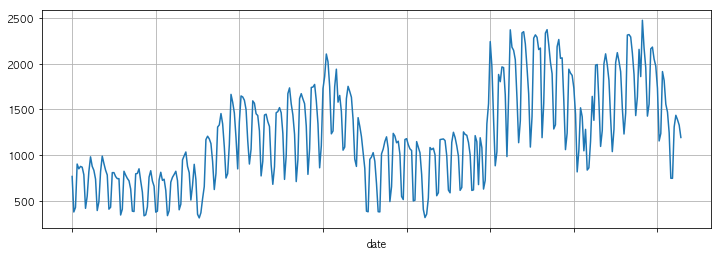

In [4]:
pinkwink_web['hit'].plot(figsize=(12,4), grid=True);

- `;` 을 안찍으면 객체정보도 같이 출력됨

- 단순히 2016년 7월 1일부터 2017년 6월 16일까지 유입량을 그림

In [5]:
time = np.arange(0, len(pinkwink_web))
traffic = pinkwink_web['hit'].values

fx = np.linspace(0, time[-1], 1000)

- 더 정확한 주기성을 확인
- 먼저 시간축(time)을 만들고 웹 트래픽의 자료를 traffic 변수에 저장

In [6]:
def error(f, x, y):
    return np.sqrt(np.mean((f(x)-y)**2))

- 어떤 데이터를 어떤 모델로 표현하려면 그 모델의 적합성을 확인하는 과정이 필요
- 참 값을 비교해서 에러를 계산해야 함

In [7]:
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

fp2 = np.polyfit(time, traffic, 2)
f2 = np.poly1d(fp2)

fp3 = np.polyfit(time, traffic, 3)
f3 = np.poly1d(fp3)

fp15 = np.polyfit(time, traffic, 15)
f15 = np.poly1d(fp15)

print(error(f1 ,time, traffic))
print(error(f2 ,time, traffic))
print(error(f3 ,time, traffic))
print(error(f15 ,time, traffic))

430.8597308110963
430.62841018946955
429.53280466762925
330.4777306662722


- 현재 데이터를 간단한 모델로 표현하는 작업을 **회귀(regression)** 이라고 함.
- 1차, 2차, 3차, 15차 다항식으로 표현한 결과를 확인
- chap1 에서 사용했던  `polyfit`와 `poly1d`를 사ㅛㅇ해서 함수로 표현
- 1차,2차,3차,15차 함수를 확인한 결과 1,2,3차는 에러가 비슷

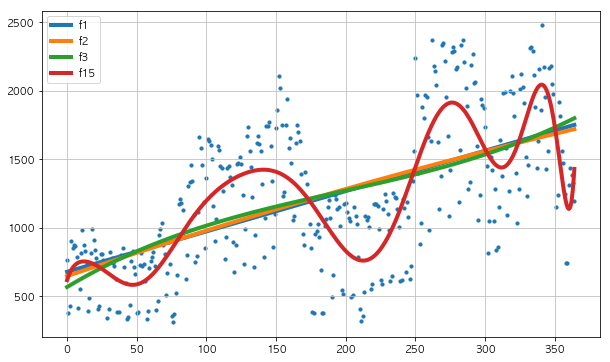

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s=10)

plt.plot(fx, f1(fx), lw=4, label='f1')
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.75')

plt.legend(loc=2)
plt.show()

- 결과를 그래프로 표현
- 2차나 3차로 표현하려면 그냥 1차로 표현하는 것이 나아보임
- 15차 함수를 사용하는 것은 과적합(over-fitting)

## 7-2. Prophet 모듈을 이용한  forecase 예측

- pinkwink_web 변수에서 날짜(index)와 방문서(hit)만 따로 저장

In [9]:
df = pd.DataFrame({'ds':pinkwink_web.index, 'y':pinkwink_web['hit']})
df.reset_index(inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%y. %m. %d.')
del df['date']

m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(df);

- pandas가 지원하는 to_datetime 함수를 이용해 날짜라고 선언
- Prophet 함수를 사용할 때 주기성이 연단위(yearly_seasonality)로 있다고 알려줌

In [10]:
future = m.make_future_dataframe(periods=60)
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


- `make_future_dataframe(periods=60)` : 이후 60일간의 데이터를 예측

In [11]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,910.186265,696.530425,1129.960981
421,2017-08-26,495.150075,264.710499,703.334639
422,2017-08-27,627.716799,426.373299,853.024833
423,2017-08-28,1180.359753,987.879855,1393.340639
424,2017-08-29,1216.280229,994.592510,1426.298058


- 예측한 데이터를 forecast 변수에 저장

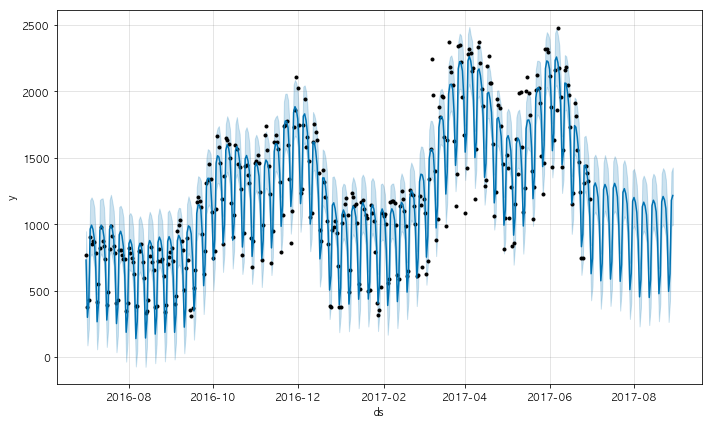

In [12]:
m.plot(forecast);

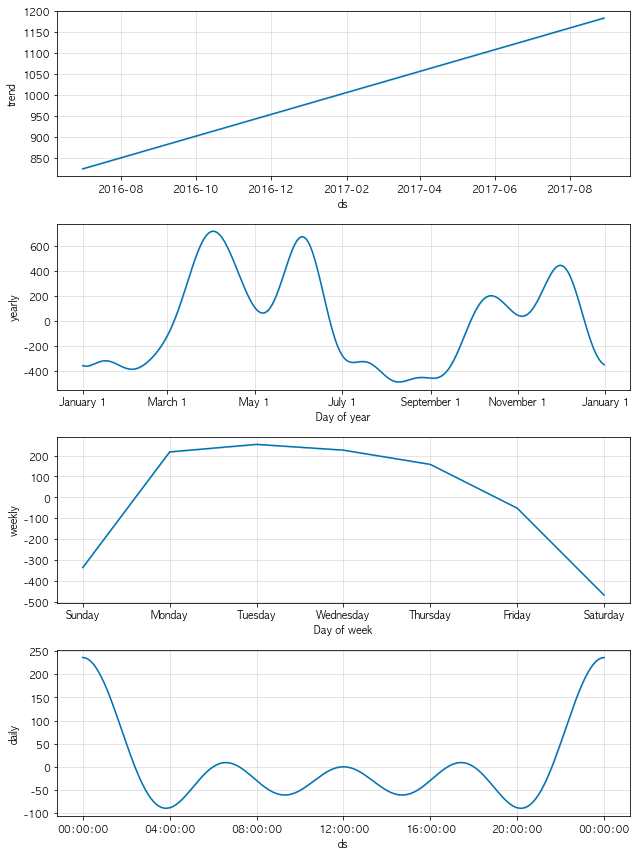

In [13]:
m.plot_components(forecast);

- 빈약하긴 하지만 이러한 과정을 **Seasonal 시계열 데이터 분석(Seasonal Time Series Data Analysis)**라고 함

## 7-3. Seasonal 시계열 분석으로 주식 데이터 분석하기

- `DataReader`함수 : 구글이 제공하는 주가 정보를 받아오는 Pandas 기능
- 종목 코드를 알면 한국 kospi 주가 정보도 받아올 수 있음  
  
- 현재 구글(현재 안됨)이나 야후에서 pandas의 주식 데이터를 읽어오는데 문자가 있음. 아직 issue 해결은 안되었음
- `fix_yahoo_finance` 모듈을 설치하여 해결  

- 기아자동차(00270)의 1990년 1월 1일부터 2017년 6월 30일까지의 주가 정보를 받아서 간단한 종가(Close) 기준으로 그래프를 그림

In [14]:
from pandas_datareader import data
import fix_yahoo_finance as yf
yf.pdr_override()

start_date = '1990-1-1' 
end_date = '2017-6-30' 
KIA = data.get_data_yahoo('000270.KS', start_date, end_date)
    
# KIA = web.DataReader('KRX:000270','google',start,end) # 구글용... 동작이 안됨
# KIA = web.DataReader('000270.KS','yahoo',start,end) # 구글용... 동작이 안됨
KIA.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,7404.520020,7665.240234,7300.229980,7665.240234,5963.754395,636300
2000-01-05,7404.520020,7404.520020,7248.089844,7248.089844,5639.200684,686100
2000-01-06,7331.520020,7519.240234,6935.220215,6935.220215,5395.779297,379000
2000-01-07,6987.359863,7143.799805,6778.790039,6778.790039,5274.072754,701400
2000-01-10,6841.359863,7102.080078,6810.069824,7091.649902,5517.486816,1076700


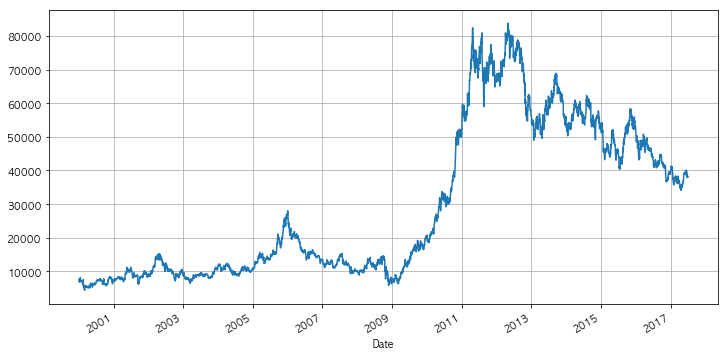

In [15]:
KIA['Close'].plot(figsize=(12,6), grid=True);

- 2012년 이후 전반적인 하락세
- 참 값과 비교를 위해 일부 데이터를 잘라서 먼저 forecast를 수행

In [16]:
KIA_trunc = KIA[:'2016-12-31']
KIA_trunc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,7404.520020,7665.240234,7300.229980,7665.240234,5963.754395,636300
2000-01-05,7404.520020,7404.520020,7248.089844,7248.089844,5639.200684,686100
2000-01-06,7331.520020,7519.240234,6935.220215,6935.220215,5395.779297,379000
2000-01-07,6987.359863,7143.799805,6778.790039,6778.790039,5274.072754,701400
2000-01-10,6841.359863,7102.080078,6810.069824,7091.649902,5517.486816,1076700
2000-01-11,7143.799805,7717.390137,7143.799805,7717.390137,6004.329590,1127200
2000-01-12,7717.390137,8447.410156,7300.229980,7508.810059,5842.046875,1606600
2000-01-13,7696.529785,7696.529785,7195.939941,7195.939941,5598.626953,702700
2000-01-14,7195.939941,7508.810059,6987.359863,7508.810059,5842.046875,843900


- 별도의 데이터 프레임을 생성

In [17]:
df = pd.DataFrame({'ds':KIA_trunc.index, 'y':KIA_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']
df.head()

,ds,y
0,2000-01-04,7665.240234
1,2000-01-05,7248.089844
2,2000-01-06,6935.220215
3,2000-01-07,6778.790039
4,2000-01-10,7091.649902


- 1년후(365)의 정보를 예측

In [18]:
m = Prophet(daily_seasonality=True)
m.fit(df);

In [19]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
4578,2017-12-25
4579,2017-12-26
4580,2017-12-27
4581,2017-12-28
4582,2017-12-29


In [20]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4578,2017-12-25,35663.418112,26704.291612,43480.284513
4579,2017-12-26,35708.690629,26169.220231,44216.803781
4580,2017-12-27,35678.140798,26624.541233,44217.028512
4581,2017-12-28,35643.482941,25803.642264,44203.081357
4582,2017-12-29,35579.997515,26276.130651,44058.540244


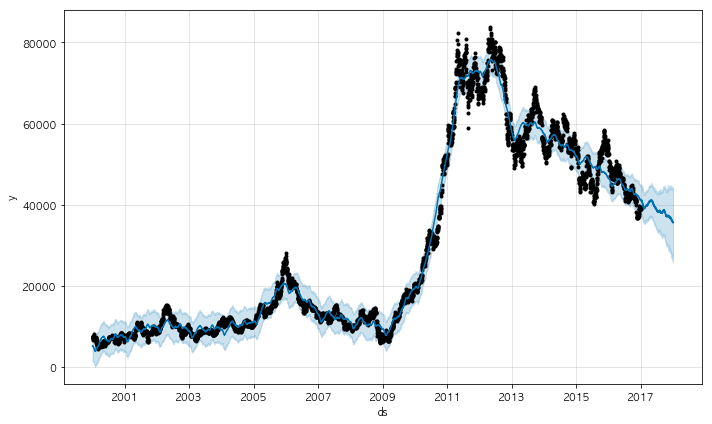

In [21]:
m.plot(forecast);

- 요소별로 확인

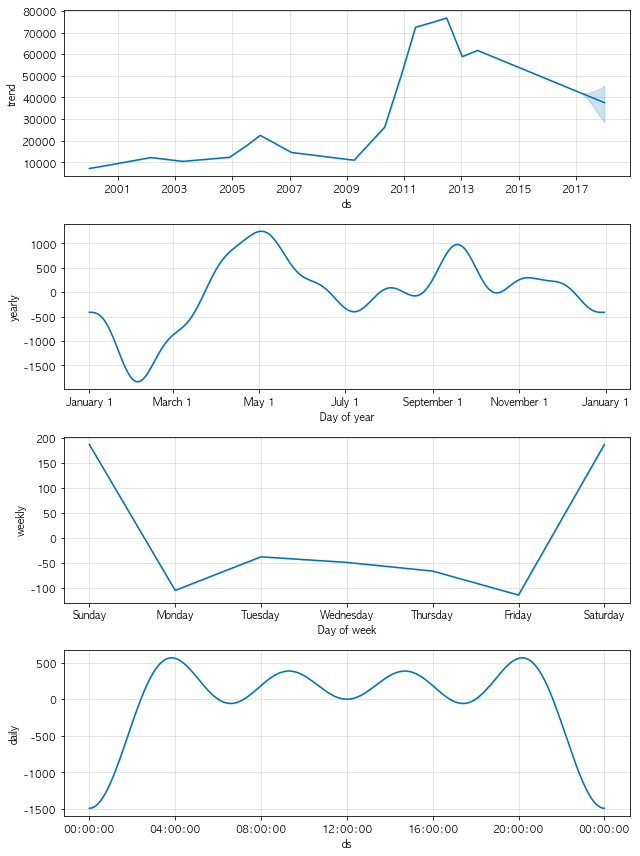

In [22]:
m.plot_components(forecast);

- 주가를 가져오는 날짜를 바꿔서 다시 예측 성능을 확인
- 받아온 데이터는 2017년 7월 31일

[*********************100%***********************]  1 of 1 downloaded


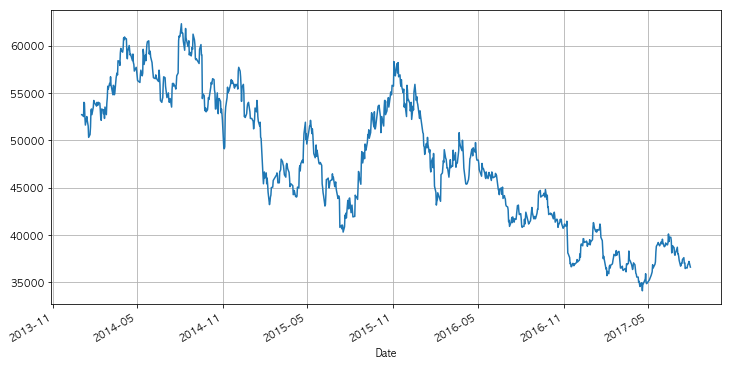

In [23]:
start_date = '2014-1-1' 
end_date = '2017-7-31' 
KIA = data.get_data_yahoo('000270.KS', start_date, end_date)
KIA['Close'].plot(figsize=(12,6), grid=True);

- 예측용으로 사용할 데이터는 5월 31일

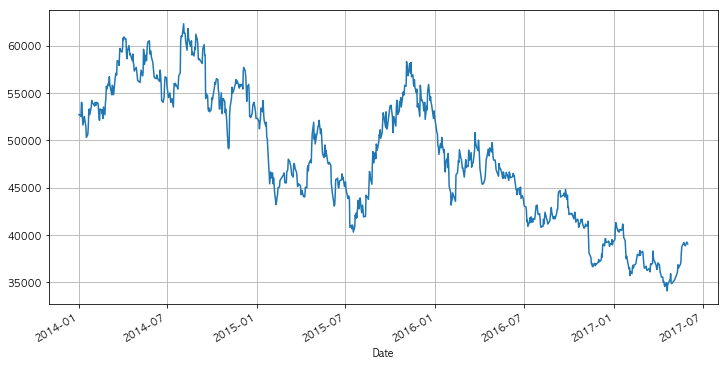

In [24]:
KIA_trunc = KIA[:'2017-05-31']
KIA_trunc['Close'].plot(figsize=(12,6), grid=True)

In [25]:
df = pd.DataFrame({'ds':KIA_trunc.index, 'y':KIA_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']

- 61일간 데이터를 예측

In [26]:
m = Prophet(daily_seasonality=True)
m.fit(df);

In [27]:
future = m.make_future_dataframe(periods=61)
future.tail()

,ds
897,2017-07-27
898,2017-07-28
899,2017-07-29
900,2017-07-30
901,2017-07-31


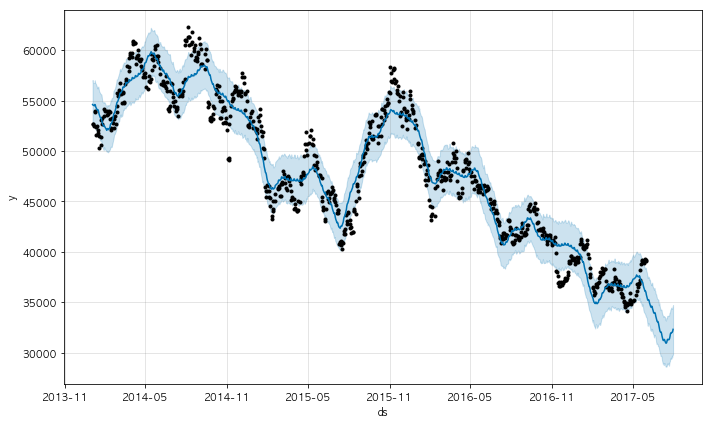

In [28]:
forecast = m.predict(future)
m.plot(forecast);

- 2개월 데이터의 참 값을 알고 있으므로 직접 비교

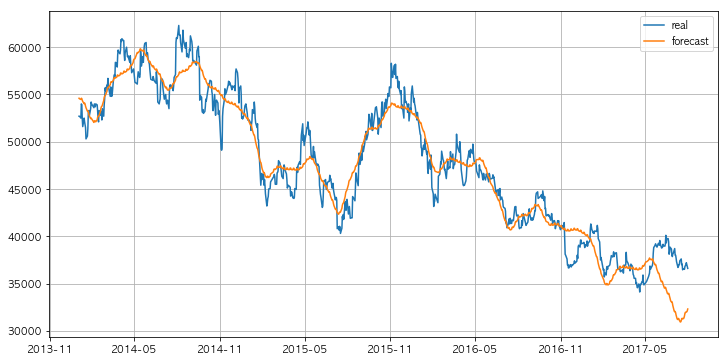

In [29]:
plt.figure(figsize=(12,6))
plt.plot(KIA.index, KIA['Close'], label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()